In [1]:
!pip install scipy pyproj xarray numpy h5py

In [2]:
#training INSAT file
import h5py
import numpy as np
import xarray as xr
import pyproj
from scipy.interpolate import griddata

# INSAT file path
insat_path = "/kaggle/input/insat-level-1c/3RIMG_28MAY2025_0015_L1C_ASIA_MER_V01R00.h5"

with h5py.File(insat_path, "r") as insat_file:
    # Read coordinates and data
    x = insat_file["X"][:]
    y = insat_file["Y"][:]
    tir1 = insat_file["IMG_TIR1"][0]
    tir2 = insat_file["IMG_TIR2"][0]
    wv = insat_file["IMG_WV"][0]
    greycount = insat_file["GreyCount"][:]
    tir1_temp = insat_file["IMG_TIR1_TEMP"][:]
    tir2_temp = insat_file["IMG_TIR2_TEMP"][:]
    wv_temp = insat_file["IMG_WV_TEMP"][:]

    # Projection conversion
    xx, yy = np.meshgrid(x, y)
    proj = pyproj.Proj(proj='merc', lat_ts=17.75, lon_0=77.25, x_0=0, y_0=0,
                       a=6378137.0, b=6356752.3142, datum='WGS84')
    lon, lat = proj(xx, yy, inverse=True)

# Flatten and interpolate
lat_flat = lat.flatten()
lon_flat = lon.flatten()
tir1_flat = tir1.flatten()
tir2_flat = tir2.flatten()
wv_flat = wv.flatten()

# Regular grid
lat_grid = np.arange(lat.min(), lat.max(), 0.10)
lon_grid = np.arange(lon.min(), lon.max(), 0.10)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

tir1_interp = griddata((lat_flat, lon_flat), tir1_flat, (lat2d, lon2d), method='linear')
tir2_interp = griddata((lat_flat, lon_flat), tir2_flat, (lat2d, lon2d), method='linear')
wv_interp = griddata((lat_flat, lon_flat), wv_flat, (lat2d, lon2d), method='linear')

# Convert counts to brightness temperatures
tir1_int = np.clip(tir1_interp.astype(int), 0, len(tir1_temp) - 1)
tir2_int = np.clip(tir2_interp.astype(int), 0, len(tir2_temp) - 1)
wv_int = np.clip(wv_interp.astype(int), 0, len(wv_temp) - 1)

tir1_temp_grid = tir1_temp[tir1_int]
tir2_temp_grid = tir2_temp[tir2_int]
wv_temp_grid = wv_temp[wv_int]

# Derived fields
difference_tir = tir1_temp_grid - tir2_temp_grid
difference_tir1_wv = tir1_temp_grid - wv_temp_grid
difference_tir2_wv = tir1_temp_grid - wv_temp_grid
division_tir = np.divide(tir1_temp_grid, tir2_temp_grid, out=np.full_like(tir1_temp_grid, np.nan), where=tir2_temp_grid != 0)

# Build xarray dataset
insat_output = xr.Dataset(
    {
        "IMG_TIR1": (("lat", "lon"), tir1_interp),
        "IMG_TIR2": (("lat", "lon"), tir2_interp),
        "IMG_WV": (("lat", "lon"), wv_interp),
        "IMG_TIR1_TB": (("lat", "lon"), tir1_temp_grid),
        "IMG_TIR2_TB": (("lat", "lon"), tir2_temp_grid),
        "IMG_WV_TB": (("lat", "lon"), wv_temp_grid),
        "TIR_TB_DIFFERENCE": (("lat", "lon"), difference_tir),
        "TIR_TB_DIVISION": (("lat", "lon"), division_tir),
        "TIR1_WV_TB_DIFFERENCE": (("lat", "lon"), difference_tir1_wv),
        "TIR2_WV_TB_DIFFERENCE": (("lat", "lon"), difference_tir2_wv),
        "GreyCount": (("GreyCount",), greycount),
        "IMG_TIR1_TEMP_COUNT": (("TIR1_TEMP_count",), tir1_temp),
        "IMG_TIR2_TEMP_COUNT": (("TIR2_TEMP_count",), tir2_temp),
        "IMG_WV_TEMP_COUNT": (("WV_TEMP_count",), wv_temp)
    },
    coords={
        "lat": lat_grid,
        "lon": lon_grid
    }
)

print(insat_output)
insat_output.to_netcdf("/kaggle/working/TB_insat_output.nc")
print("✅ INSAT processing complete.")


<xarray.Dataset> Size: 19MB
Dimensions:                (lat: 556, lon: 655, GreyCount: 1024,
                            TIR1_TEMP_count: 1024, TIR2_TEMP_count: 1024,
                            WV_TEMP_count: 1024)
Coordinates:
  * GreyCount              (GreyCount) int32 4kB 0 1 2 3 ... 1020 1021 1022 1023
  * lat                    (lat) float64 4kB -10.0 -9.9 -9.8 ... 45.3 45.4 45.5
  * lon                    (lon) float64 5kB 44.5 44.6 44.7 ... 109.8 109.9
Dimensions without coordinates: TIR1_TEMP_count, TIR2_TEMP_count, WV_TEMP_count
Data variables: (12/13)
    IMG_TIR1               (lat, lon) float64 3MB 550.0 552.0 ... 575.0 578.3
    IMG_TIR2               (lat, lon) float64 3MB 585.0 585.7 ... 604.0 605.7
    IMG_WV                 (lat, lon) float64 3MB 882.0 881.0 ... 929.0 930.0
    IMG_TIR1_TB            (lat, lon) float32 1MB 293.2 292.9 ... 289.7 289.0
    IMG_TIR2_TB            (lat, lon) float32 1MB 290.2 290.2 ... 287.1 286.7
    IMG_WV_TB              (lat, lon) fl

In [3]:
# training IMERG file
import h5py
import xarray as xr
import numpy as np

# Path to the input HDF5 file
input_path = "/kaggle/input/imerg-late-run/3B-HHR-L.MS.MRG.3IMERG.20250528-S000000-E002959.0000.V07B.HDF5"
output_path = "/kaggle/working/output_precipitation_data.nc" 

# Spatial Boundary Condition
lat_min, lat_max = -10.0, 45.5
lon_min, lon_max = 44.5, 110.0

# Open the HDF5 file and extract data
with h5py.File(input_path, 'r') as f:
    # Read coordinates
    lon = f['Grid']['lon'][:]  # (3600,)
    lat = f['Grid']['lat'][:]  # (1800,)
    precip = f['Grid']['precipitation'][0, :, :]  # (lon=3600, lat=1800)

    # Replace fill values with NaN
    precip = np.where(precip == -9999.9, np.nan, precip)

# Transpose precip from (lon, lat) to (lat, lon)
precip = precip.T  # Now shape is (lat=1800, lon=3600)

# Create xarray Dataset
ds = xr.Dataset(
    {
        "precipitation": (["lat", "lon"], precip)
    },
    coords={
        "lat": lat,
        "lon": lon
    }
)

# Subset spatial bounds
ds_subset = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Assign attributes
ds_subset["precipitation"].attrs["units"] = "mm/hr"
ds_subset["precipitation"].attrs["long_name"] = "IMERG Precipitation Rate"
ds_subset["lat"].attrs["units"] = "degrees_north"
ds_subset["lon"].attrs["units"] = "degrees_east"

# Save to NetCDF
ds_subset.to_netcdf(output_path)
print(f"Subset data saved to: {output_path}")

Subset data saved to: /kaggle/working/output_precipitation_data.nc


2025-06-24 05:27:43.794949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750742864.048234      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750742864.118374      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


After filtering: 61366 samples remain
Rainfall mean: 1.2442
Input shape: 7, Train: 49092, Test: 12274


I0000 00:00:1750742879.619790      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1750742882.327738     102 service.cc:148] XLA service 0x78723c002960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750742882.328529     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750742882.548188     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 58.2720 - mae: 1.3595 - rmse: 3.0433

I0000 00:00:1750742883.366721     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 58.0994 - mae: 1.3271 - rmse: 3.0272 - val_loss: 60.6519 - val_mae: 1.3225 - val_rmse: 3.0676
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 56.4836 - mae: 1.2571 - rmse: 2.9744 - val_loss: 59.7230 - val_mae: 1.2676 - val_rmse: 3.0308
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 56.4682 - mae: 1.2048 - rmse: 2.9542 - val_loss: 58.8758 - val_mae: 1.2340 - val_rmse: 2.9988
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 55.6199 - mae: 1.1831 - rmse: 2.9244 - val_loss: 58.0845 - val_mae: 1.2180 - val_rmse: 2.9704
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 53.3231 - mae: 1.1563 - rmse: 2.8624 - val_loss: 57.3213 - val_mae: 1.2131 - val_rmse: 2.9445
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 54.7689 - mae: 1.1701 - rmse: 2.8859 - val_loss: 56.5577 - val_mae: 1.2163 - val_rmse: 2.9202
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51.7406 - mae: 1.1635 - rmse: 2.8132 - va

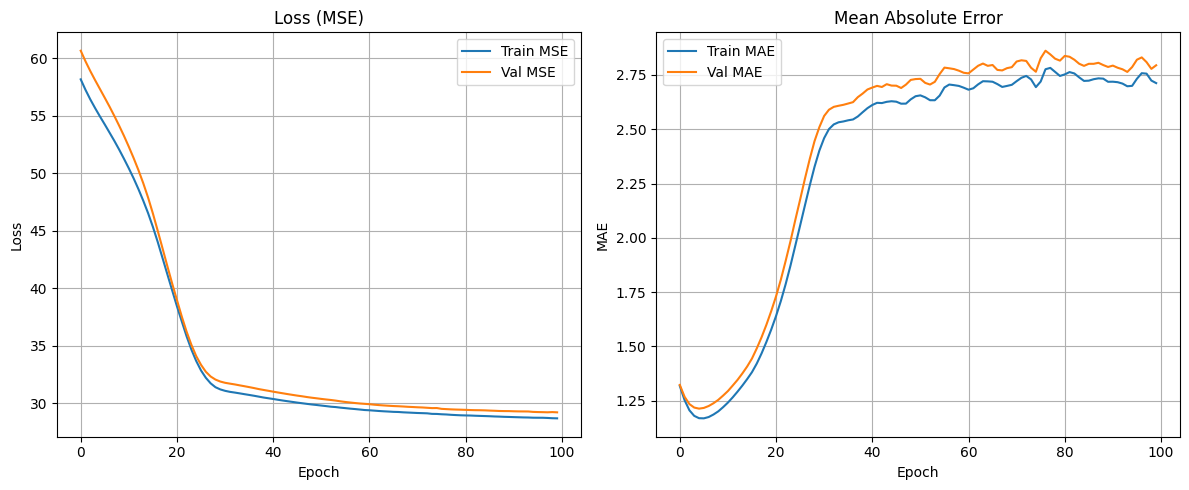

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation by Rainfall Intensity Bin (Test Set):
Range 0-2 mm/hr: RMSE = 3.661, MAE = 2.644, Samples = 10261
Range 2-5 mm/hr: RMSE = 3.441, MAE = 2.808, Samples = 1275
Range 5-8 mm/hr: RMSE = 2.966, MAE = 2.471, Samples = 350
Range 8-inf mm/hr: RMSE = 8.692, MAE = 7.022, Samples = 388
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


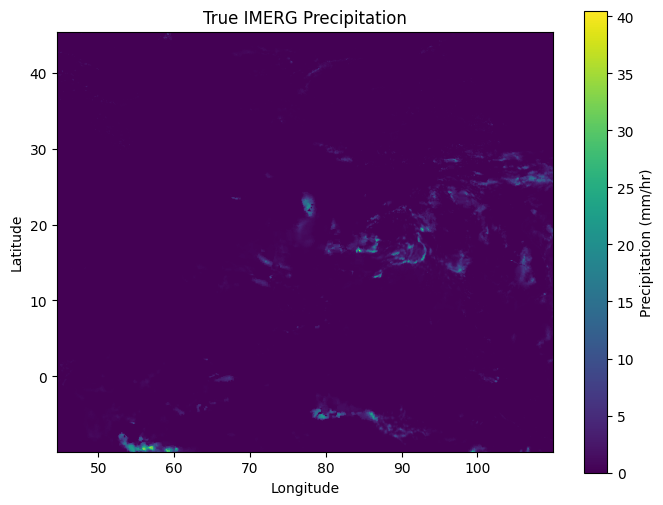

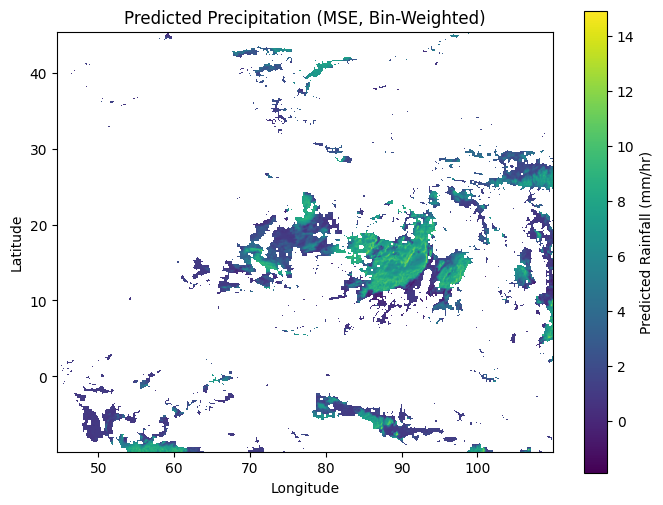

✅ Model and scaler saved successfully.


In [4]:
#!/usr/bin/env python

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# File paths
insat = "/kaggle/working/TB_insat_output.nc"
imerg = "/kaggle/working/output_precipitation_data.nc"
MODEL_SAVE_PATH = "insat_imerg_ann_model_mse.h5"

LEARNING_RATE = 0.0005
EPOCHS = 100
BATCH_SIZE = 8000

# Load data
ds = xr.open_dataset(insat)
imrg = xr.open_dataset(imerg)

if 'time' in ds.dims:
    ds = ds.squeeze('time', drop=True)
if 'time' in imrg.dims:
    imrg = imrg.squeeze('time', drop=True)

# Align insat and imerg
ds_interp = ds.interp(lat=imrg['lat'], lon=imrg['lon'], method="linear")

features = [
    'IMG_TIR1_TB', 'IMG_TIR2_TB', 'IMG_WV_TB',
    'TIR1_WV_TB_DIFFERENCE', 'TIR2_WV_TB_DIFFERENCE',
    'TIR_TB_DIVISION', 'TIR_TB_DIFFERENCE'
]
X = np.stack([ds_interp[feat].values.flatten() for feat in features], axis=1)
y = imrg['precipitation'].values.flatten()

mask = np.isfinite(X).all(axis=1) & np.isfinite(y) & (y > 0)
X = X[mask]
y = y[mask]

# Sample Weights
rain_bins = np.digitize(y, bins=[2, 5, 8])  # bins: 0: <1, 1:1–5, 2:5–10, 3:>10
bin_weights = np.array([2, 4, 8.0, 25.0])
sample_weights = bin_weights[rain_bins]
sample_weights /= np.mean(sample_weights)

print(f"After filtering: {X.shape[0]} samples remain")
print(f"Rainfall mean: {y.mean():.4f}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dataset splitting
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X_scaled, y, sample_weights, test_size=0.2, random_state=42
)

input_shape = X_train.shape[1]
print(f"Input shape: {input_shape}, Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Model Defination
model = Sequential([
    Dense(50, input_dim=input_shape, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
             tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()

# train model
history = model.fit(
    X_train, y_train,
    sample_weight=sw_train,
    validation_data=(X_test, y_test, sw_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Save model to h5
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to: {MODEL_SAVE_PATH}")

# Learning plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Bin evaluation
y_pred_test = model.predict(X_test).flatten()
test_bins = np.digitize(y_test, bins=[2, 5, 8])
bin_names = ["0-2", "2-5", "5-8", "8-inf"]

print("📊 Evaluation by Rainfall Intensity Bin (Test Set):")
for i, label in enumerate(bin_names):
    idx = np.where(test_bins == i)[0]
    if len(idx) == 0:
        continue
    rmse = np.sqrt(mean_squared_error(y_test[idx], y_pred_test[idx]))
    mae = mean_absolute_error(y_test[idx], y_pred_test[idx])
    print(f"Range {label} mm/hr: RMSE = {rmse:.3f}, MAE = {mae:.3f}, Samples = {len(idx)}")

# Grid prediction
X_full = np.stack([ds_interp[feat].values.flatten() for feat in features], axis=1)
y_full = imrg['precipitation'].values.flatten()
mask_full = np.isfinite(X_full).all(axis=1) & np.isfinite(y_full) & (y_full > 0)

X_full_scaled = scaler.transform(X_full[mask_full])
y_pred_flat = model.predict(X_full_scaled).flatten()

y_pred_full = np.full(y_full.shape, np.nan)
y_pred_full[mask_full] = y_pred_flat
predicted_grid = y_pred_full.reshape(imrg['precipitation'].shape)

# PLots
plt.figure(figsize=(8, 6))
plt.imshow(imrg['precipitation'].values, origin='lower', cmap='viridis',
           extent=[float(imrg['lon'].min()), float(imrg['lon'].max()),
                   float(imrg['lat'].min()), float(imrg['lat'].max())])
plt.colorbar(label='Precipitation (mm/hr)')
plt.title("True IMERG Precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(predicted_grid, origin='lower', cmap='viridis',
           extent=[float(imrg['lon'].min()), float(imrg['lon'].max()),
                   float(imrg['lat'].min()), float(imrg['lat'].max())])
plt.colorbar(label='Predicted Rainfall (mm/hr)')
plt.title("Predicted Precipitation (MSE, Bin-Weighted)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()


import joblib

# Save model (architecture + weights + optimizer)
model.save("insat_imerg_ann_model_mse.h5")

# Save the StandardScaler used for input normalization
joblib.dump(scaler, "scaler.save")

print("✅ Model and scaler saved successfully.")


1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

📊 Evaluation Results:
  RMSE: 4.079 mm/hr
  MAE:  2.544 mm/hr
  Weighted RMSE: 7.110 mm/hr
  Weighted MAE:  4.453 mm/hr

📊 Evaluation by Rainfall Intensity Bin:
  Range 0-2 mm/hr: RMSE = 3.317, MAE = 2.173, Samples = 50394
  Range 2-5 mm/hr: RMSE = 2.750, MAE = 2.264, Samples = 5692
  Range 5-8 mm/hr: RMSE = 4.493, MAE = 4.165, Samples = 1629
  Range 8-inf mm/hr: RMSE = 14.047, MAE = 12.210, Samples = 1826


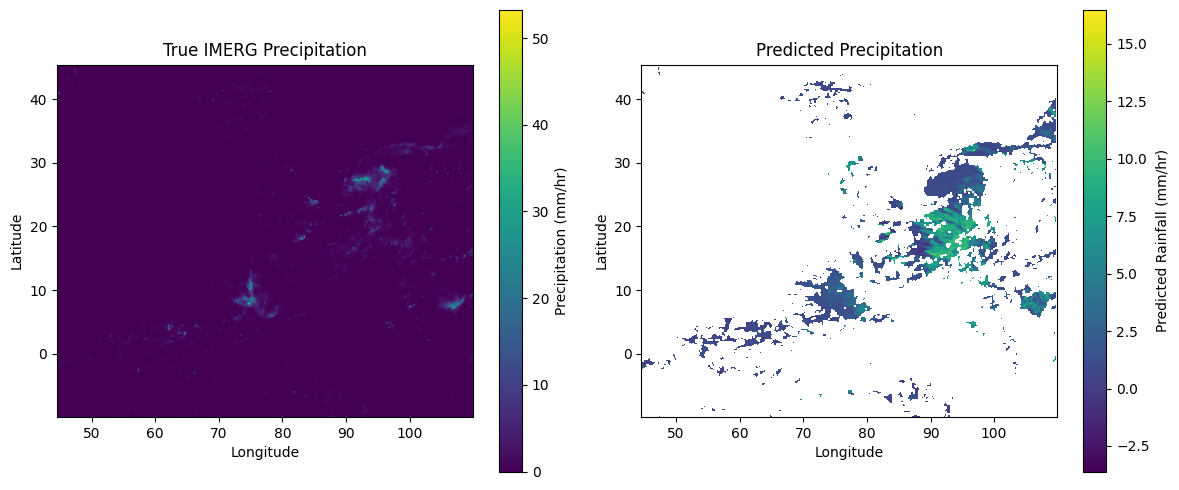

In [5]:
# model validation

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

# Files path
INSAT_FILE = "/kaggle/input/nc-insat/3RIMG_30MAY2025_1015_L1C_ASIA_MER_V01R00.nc"
IMERG_FILE = "/kaggle/input/nc-imerg/3B-HHR-L.MS.MRG.3IMERG.20250530-S100000-E102959.0600.V07B.nc"
MODEL_PATH = "insat_imerg_ann_model_mse.h5"
SCALER_PATH = "scaler.save"

# model
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# load data
ds = xr.open_dataset(INSAT_FILE)
imrg = xr.open_dataset(IMERG_FILE)

if 'time' in ds.dims:
    ds = ds.squeeze('time', drop=True)
if 'time' in imrg.dims:
    imrg = imrg.squeeze('time', drop=True)

# Interpolate INSAT to IMERG grid
ds_interp = ds.interp(lat=imrg['lat'], lon=imrg['lon'], method="linear")

# Variable or Feature extraction
features = [
    'IMG_TIR1_TB', 'IMG_TIR2_TB', 'IMG_WV_TB',
    'TIR1_WV_TB_DIFFERENCE', 'TIR2_WV_TB_DIFFERENCE',
    'TIR_TB_DIVISION', 'TIR_TB_DIFFERENCE'
]

X_full = np.stack([ds_interp[feat].values.flatten() for feat in features], axis=1)
y_full = imrg['precipitation'].values.flatten()

# Mask for valid data
mask = np.isfinite(X_full).all(axis=1) & np.isfinite(y_full) & (y_full > 0)
X_valid = X_full[mask]
y_valid = y_full[mask]

X_scaled = scaler.transform(X_valid)

# Prediction
y_pred = model.predict(X_scaled).flatten()

# Statistics
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)

# Bin-based weights and weighted average metrics
rain_bins = np.digitize(y_valid, bins=[2, 5, 8])
bin_weights = np.array([2, 4, 8.0, 20.0])
sample_weights = bin_weights[rain_bins]
sample_weights /= np.mean(sample_weights)

weighted_mse = np.average((y_valid - y_pred)**2, weights=sample_weights)
weighted_rmse = np.sqrt(weighted_mse)
weighted_mae = np.average(np.abs(y_valid - y_pred), weights=sample_weights)

print("\n📊 Evaluation Results:")
print(f"  RMSE: {rmse:.3f} mm/hr")
print(f"  MAE:  {mae:.3f} mm/hr")
print(f"  Weighted RMSE: {weighted_rmse:.3f} mm/hr")
print(f"  Weighted MAE:  {weighted_mae:.3f} mm/hr")

# BIn-wise evaluation
bin_names = ["0-2", "2-5", "5-8", "8-inf"]
print("\n📊 Evaluation by Rainfall Intensity Bin:")
for i, label in enumerate(bin_names):
    idx = np.where(rain_bins == i)[0]
    if len(idx) == 0:
        continue
    rmse_i = np.sqrt(mean_squared_error(y_valid[idx], y_pred[idx]))
    mae_i = mean_absolute_error(y_valid[idx], y_pred[idx])
    print(f"  Range {label} mm/hr: RMSE = {rmse_i:.3f}, MAE = {mae_i:.3f}, Samples = {len(idx)}")


# Reconstruct full grid for plotting
y_pred_grid = np.full_like(y_full, np.nan)
y_pred_grid[mask] = y_pred
predicted_map = y_pred_grid.reshape(imrg['precipitation'].shape)

# Plot Ground Truth and Prediction
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(imrg['precipitation'].values, origin='lower', cmap='viridis',
           extent=[float(imrg['lon'].min()), float(imrg['lon'].max()),
                   float(imrg['lat'].min()), float(imrg['lat'].max())])
plt.colorbar(label='Precipitation (mm/hr)')
plt.title("True IMERG Precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(1, 2, 2)
plt.imshow(predicted_map, origin='lower', cmap='viridis',
           extent=[float(imrg['lon'].min()), float(imrg['lon'].max()),
                   float(imrg['lat'].min()), float(imrg['lat'].max())])
plt.colorbar(label='Predicted Rainfall (mm/hr)')
plt.title("Predicted Precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()
